# Univariate Natural Selection Simulations

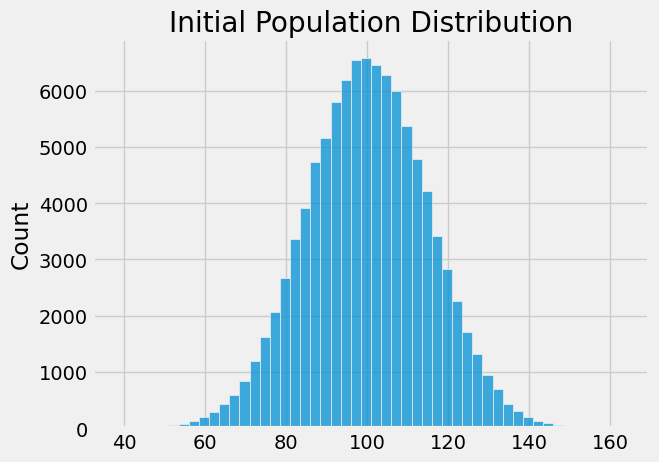

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as graph
import seaborn as sns
from tqdm import trange

graph.style.use("fivethirtyeight")

mu, sd = 100, 15
n_generations = 100
SELECTION_STRENGTH = 0.5  # 0 = uniform fitness, 1 = full selection, >1 = stronger selection
HERITABILITY = 0.75

initial_population = stats.norm(mu, sd).rvs(100_000)

graph.title("Initial Population Distribution")
sns.histplot(initial_population, bins=50)
graph.show()


def random_mating(population):
    """
    Randomly shuffle and pair up the population.
    """
    shuffled = population.copy()
    np.random.shuffle(shuffled)
    # Create pairs: reshape into (n_pairs, 2)
    pairs = shuffled.reshape(-1, 2)
    return pairs


def uniform_fitness(population):
    """
    Uniform fitness function: all individuals have equal fitness.
    This represents no selection pressure - neutral evolution.
    """
    # All individuals have equal fitness
    fitness = np.ones_like(population)
    # Normalize to sum to 1
    fitness /= fitness.sum()
    return fitness


def fitness_decreases_with_fitness(population):
    """
    Example fitness function: higher trait values have lower fitness.
    Fitness decreases linearly with trait value.

    Uses global selection_strength parameter:
    - selection_strength = 0: uniform fitness (no selection)
    - selection_strength = 1: full linear selection
    - selection_strength > 1: stronger selection
    - 0 < selection_strength < 1: weaker selection (flatter curve)
    """
    # Linear decrease: fitness = -trait_value (then shifted to be positive)
    fitness = -population
    # Shift to make all values positive
    fitness = fitness - fitness.min() + 1
    # Apply selection strength as an exponent to flatten/steepen the curve
    fitness = fitness ** SELECTION_STRENGTH
    # Normalize to sum to 1
    fitness /= fitness.sum()
    return fitness


def peak_at_mean_fitness(population):
    """
    Example fitness function: fitness peaks at the population mean.
    Fitness decreases as trait values move away from the mean.
    """
    mean_trait = np.mean(population)
    # Fitness decreases with distance from the mean
    fitness = -np.abs(population - mean_trait)
    # Shift to make all values positive
    fitness = fitness - fitness.min() + 1
    # Apply selection strength as an exponent to flatten/steepen the curve
    fitness = fitness ** SELECTION_STRENGTH
    # Normalize to sum to 1
    fitness /= fitness.sum()
    return fitness


def produce_offspring(parent1_trait, parent2_trait, n_offspring=2, heritability=0.5):
    """
    Produce offspring from two parents.
    Offspring trait = midparent value + genetic noise
    heritability controls how much traits are inherited vs random
    """
    midparent = (parent1_trait + parent2_trait) / 2
    # Environmental/genetic noise
    noise_sd = sd * np.sqrt(1 - heritability)
    offspring = np.random.normal(midparent, noise_sd, n_offspring)
    return offspring


def run_generation(population, fitness_function, mating_strategy):
    """Run one generation with selection: select parents based on fitness, mate, and produce offspring."""
    # Calculate fitness for each individual
    fitness = fitness_function(population)

    # Select parents based on fitness (with replacement)
    # We need len(population) parents to maintain population size
    n_parents = len(population)
    selected_indices = np.random.choice(
        len(population),
        size=n_parents,
        replace=True,
        p=fitness
    )
    selected_parents = population[selected_indices]

    # Mate the selected parents randomly
    pairs = mating_strategy(selected_parents)
    offspring_list = []

    for parent1, parent2 in pairs:
        offspring = produce_offspring(parent1, parent2)
        offspring_list.extend(offspring)

    return np.array(offspring_list)


def visualize_fitness_function(fitness_function):
    """Visualize how fitness changes with trait value.

    Args:
        fitness_function: A function that takes a population array and returns fitness values.
            Function name should end with '_fitness'.
    """
    # Create a range of trait values
    trait_values = np.linspace(0, 200, 1000)
    # Calculate fitness using the provided function
    # The function returns normalized probabilities, so multiply by length to get relative fitness
    normalized_fitness = fitness_function(trait_values)
    fitness_values = normalized_fitness * len(trait_values)

    # Extract function name for title
    func_name = fitness_function.__name__.replace('_', ' ').title()

    fig, axes = graph.subplots(2, 1, figsize=(8, 8))

    # Plot 1: Fitness vs Trait Value
    axes[0].plot(trait_values, fitness_values, linewidth=2)
    axes[0].set_xlabel('Trait Value')
    axes[0].set_ylabel('Relative Fitness')
    axes[0].set_title(f'{func_name}')
    axes[0].axvline(mu, color='red', linestyle='--', alpha=0.7, label=f'Initial mean (μ={mu})')
    axes[0].axvspan(mu - sd, mu + sd, alpha=0.2, color='red', label='±1 SD')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Same but zoomed in on the relevant range
    axes[1].plot(trait_values, fitness_values, linewidth=2)
    axes[1].set_xlabel('Trait Value')
    axes[1].set_ylabel('Relative Fitness')
    axes[1].set_title(f'{func_name} (Zoomed to Population Range)')
    axes[1].set_xlim(50, 150)
    axes[1].axvline(mu, color='red', linestyle='--', alpha=0.7, label=f'Initial mean (μ={mu})')
    axes[1].axvspan(mu - sd, mu + sd, alpha=0.2, color='red', label='±1 SD')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    graph.tight_layout()
    graph.show()


def visualize_results(population, mean_history, std_history, initial_mean, initial_sd):
    """
    Visualize simulation results with three plots:
    1. Final population distribution
    2. Mean trait value over generations
    3. Standard deviation over generations
    """
    fig, axes = graph.subplots(1, 3, figsize=(15, 6))

    # Plot 1: Final distribution
    axes[0].set_title("Final Population Distribution")
    sns.histplot(population, bins=50, ax=axes[0])
    axes[0].axvline(initial_mean, color="red", linestyle="--", label="Initial mean")
    axes[0].legend()

    # Plot 2: Mean over time
    axes[1].set_title("Mean Trait Value Over Generations")
    axes[1].plot(mean_history)
    axes[1].axhline(initial_mean, color="red", linestyle="--", label="Initial mean")
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Mean")
    axes[1].legend()

    # Plot 3: Standard deviation over time
    axes[2].set_title("Standard Deviation Over Generations")
    axes[2].plot(std_history)
    axes[2].axhline(initial_sd, color="red", linestyle="--", label="Initial SD")
    axes[2].set_xlabel("Generation")
    axes[2].set_ylabel("Standard Deviation")
    axes[2].legend()

    graph.tight_layout()
    graph.show()

Simulation: Base case
- everyone is equally likely to reproduce
- everyone mates randomly
- each pair produces 2 offspring

Generation 99: mean=100.37, sd=14.97: 100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


Final generation 100: mean=100.37, sd=14.97


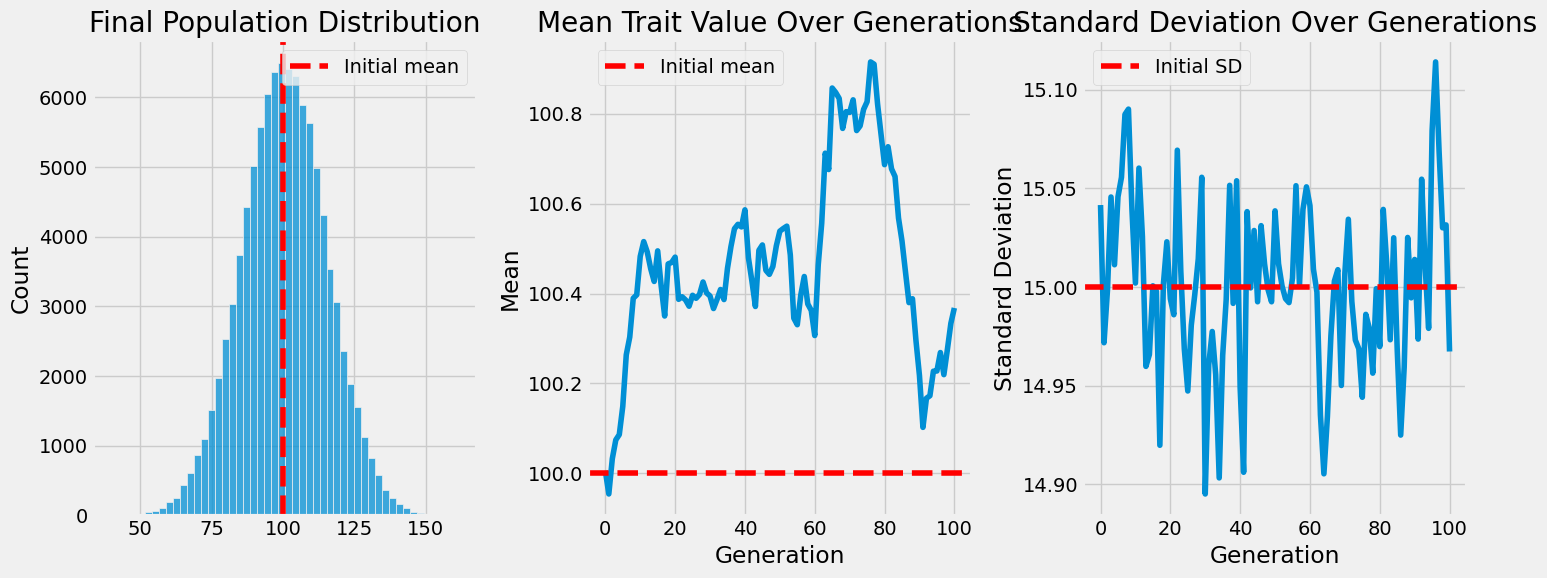

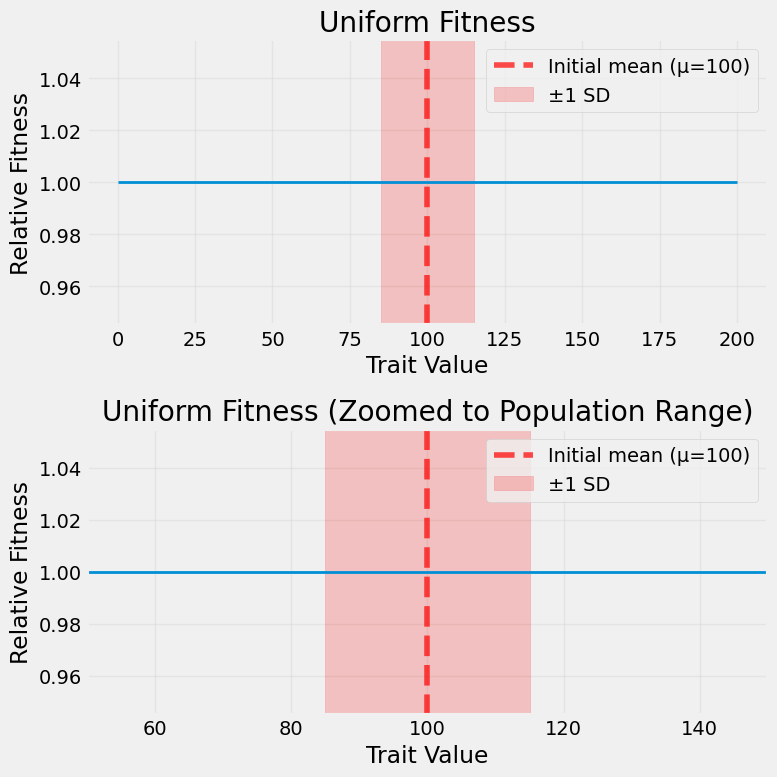

In [2]:
# Run the simulation
population = initial_population.copy()
mean_history = [population.mean()]
std_history = [population.std()]

progressor = trange(n_generations)
for generation in progressor:
    population = run_generation(
        population,
        uniform_fitness,
        random_mating
    )
    mean_history.append(population.mean())
    std_history.append(population.std())

    progressor.set_description(
        f"Generation {generation}: mean={population.mean():.2f}, sd={population.std():.2f}"
    )
print(
    f"Final generation {n_generations}: mean={population.mean():.2f}, sd={population.std():.2f}"
)

visualize_results(population, mean_history, std_history, mu, sd)
visualize_fitness_function(uniform_fitness)

Simulation: Selection case (fitness decreases with trait value)
- fitness decreases with trait value
- everyone mates randomly
- each pair produces 2 offspring

Generation 99: mean=-71.22, sd=14.84: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Final generation 100: mean=-71.22, sd=14.84


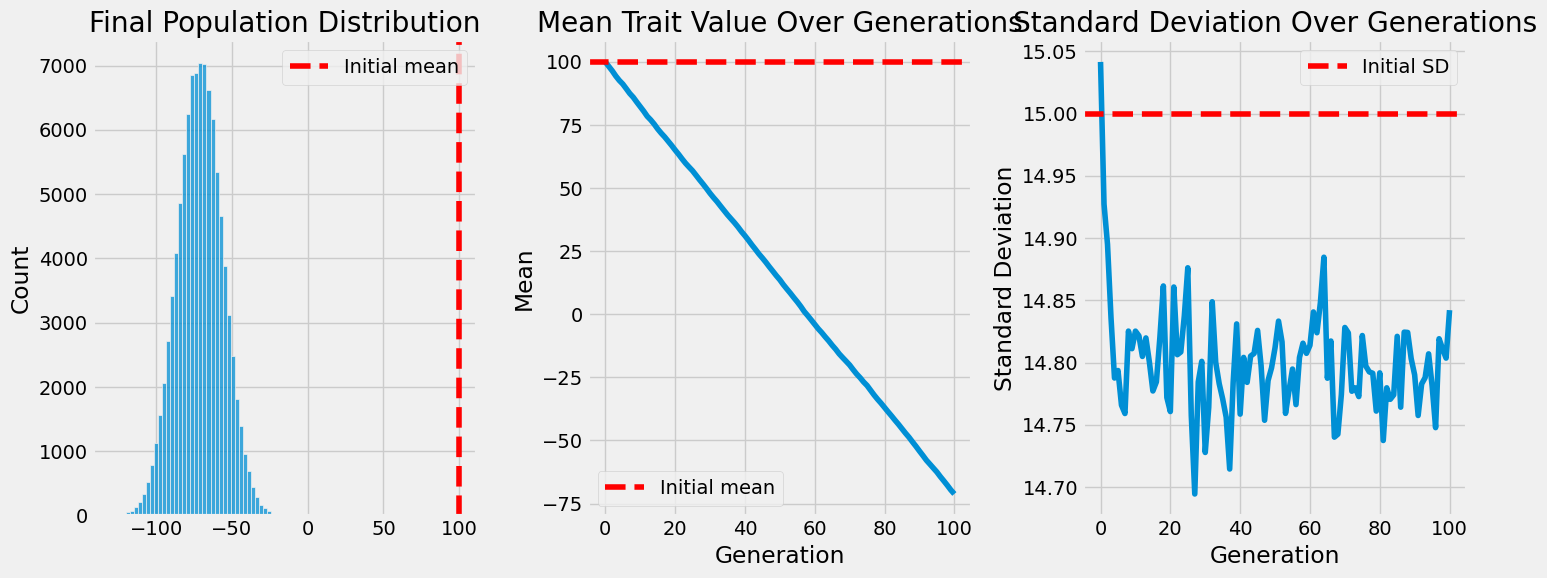

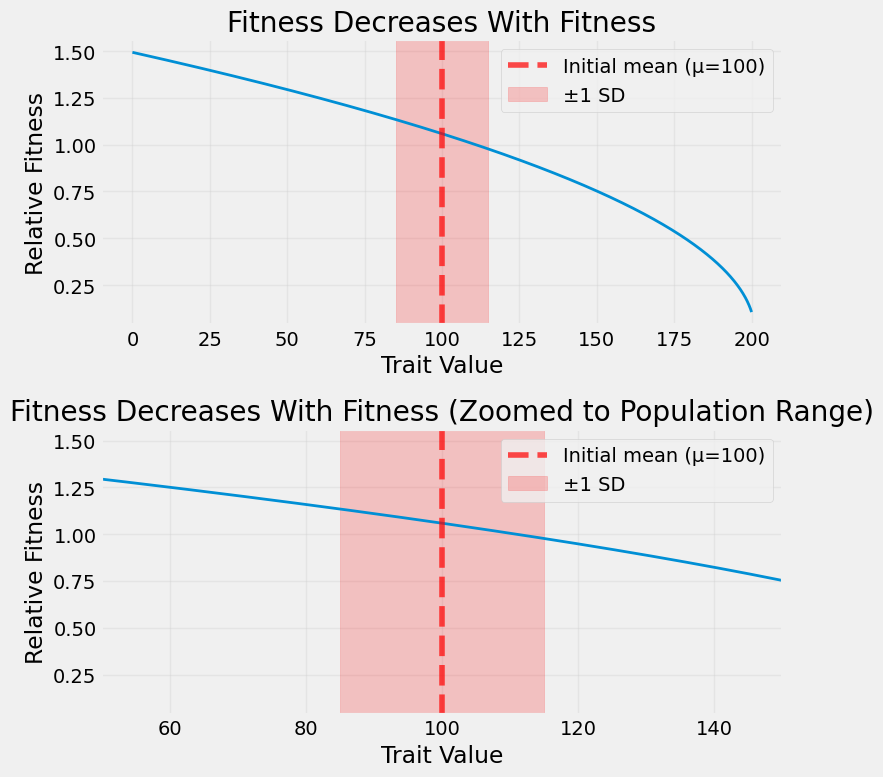

In [3]:

# Run the simulation
population = initial_population.copy()
mean_history = [population.mean()]
std_history = [population.std()]

progressor = trange(n_generations)
for generation in progressor:
    population = run_generation(
        population,
        fitness_decreases_with_fitness,
        random_mating
    )
    mean_history.append(population.mean())
    std_history.append(population.std())

    progressor.set_description(
        f"Generation {generation}: mean={population.mean():.2f}, sd={population.std():.2f}"
    )

print(
    f"Final generation {n_generations}: mean={population.mean():.2f}, sd={population.std():.2f}"
)

visualize_results(population, mean_history, std_history, mu, sd)
visualize_fitness_function(fitness_decreases_with_fitness)

Simulation: Selection case (fitness is peaked at the population mean)
- fitness peaks at the population mean
- everyone mates randomly
- each pair produces 2 offspring

Generation 99: mean=100.21, sd=14.18: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Final generation 100: mean=100.21, sd=14.18


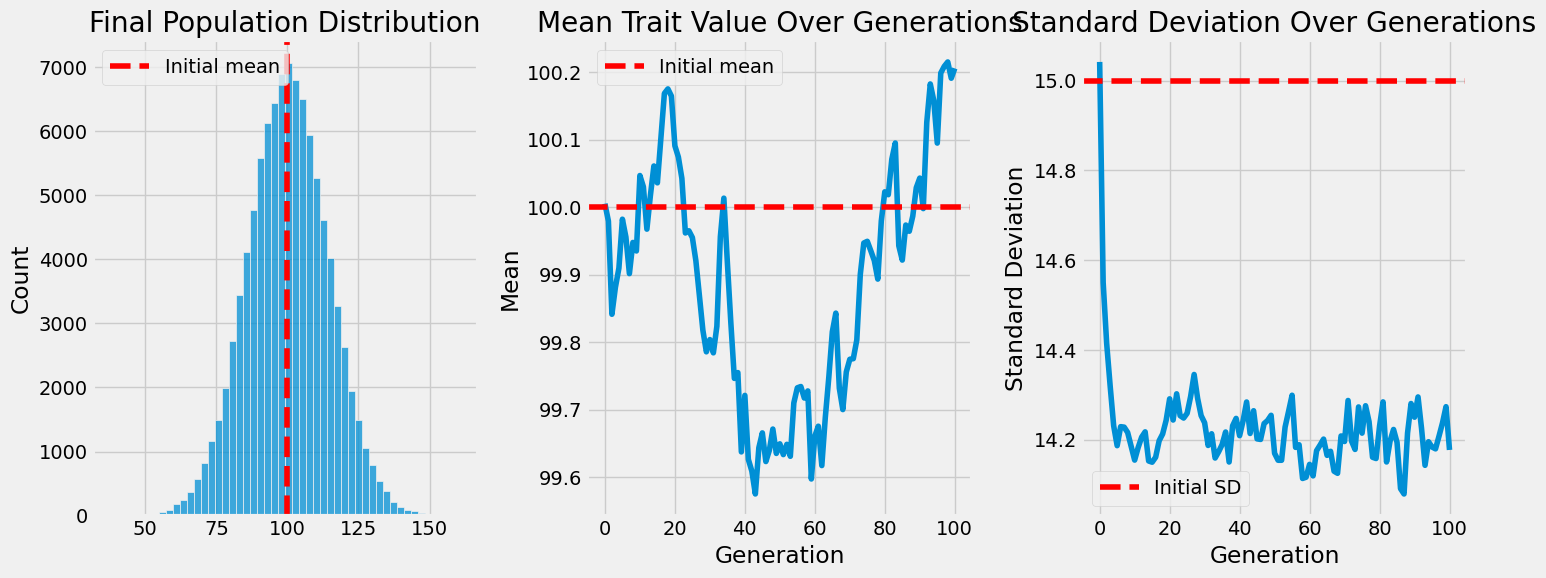

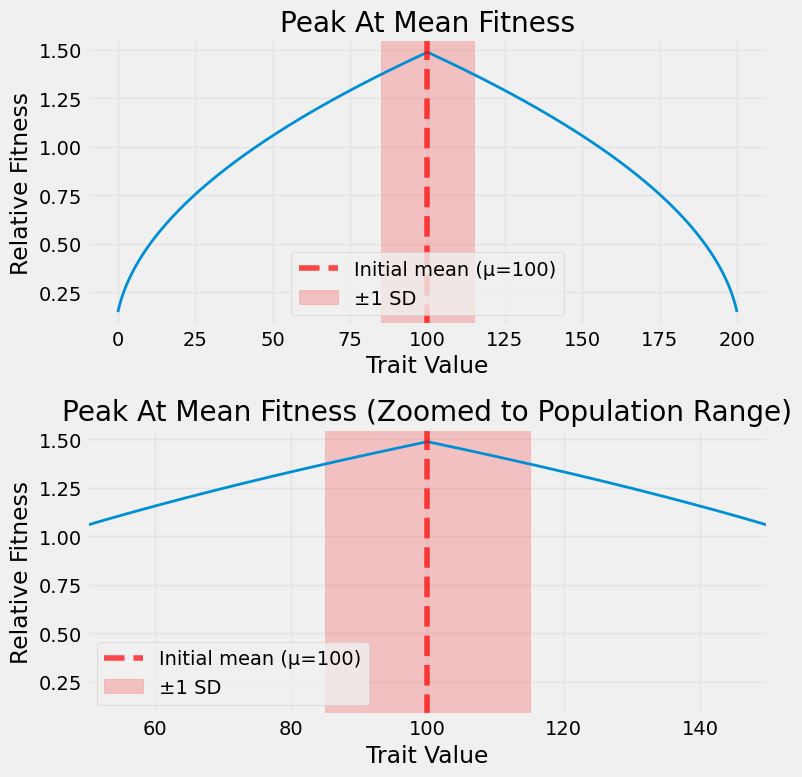

In [4]:
# Run the simulation
population = initial_population.copy()
mean_history = [population.mean()]
std_history = [population.std()]

progressor = trange(n_generations)
for generation in progressor:
    population = run_generation(
        population,
        peak_at_mean_fitness,
        random_mating
    )
    mean_history.append(population.mean())
    std_history.append(population.std())

    progressor.set_description(
        f"Generation {generation}: mean={population.mean():.2f}, sd={population.std():.2f}"
    )

print(
    f"Final generation {n_generations}: mean={population.mean():.2f}, sd={population.std():.2f}"
)

visualize_results(population, mean_history, std_history, mu, sd)
visualize_fitness_function(peak_at_mean_fitness)